In [1]:
from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[1]
import sys
sys.path.append(str(PROJECT_ROOT))
from bahamas_lig.utils import *
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.gridspec as gridspec
import itertools

In [2]:
## Styling
sns.set_palette("viridis", n_colors=6)
sns.set_style(
    "ticks",
    {
        "axes.edgecolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "axes.facecolor": "(.98,.98,.98)",
        "axes.grid": True,
        "grid.color": ".9",
        "grid.linestyle": u"-.",
    },
)
sns.set_context("talk")

In [3]:
def get_model_status(inference_dir,model_dir):

    model_posterior_dir = str(inference_dir)+'/'+str('arviz_traces_2021')
    model_posterior_list=[o[:-3] for o in os.listdir(model_posterior_dir) if '.nc' in o]

    model_predict_dir = str(inference_dir)+'/'+str('pymc3_post_predict_2021')
    model_predict_list=[o[:-4] for o in os.listdir(model_predict_dir) if '.pkl' in o]

    model_files_dir = str(model_dir)
    model_files_raw=[o for o in os.listdir(model_files_dir) if '.dat' in o]
    unique_models=list(set(['_'.join(a.split('_')[:-1]) for a in model_files_raw]))


    model_weights = pd.read_csv(str(inference_dir)+'/'+str('model_weights/model_weights.csv'),index_col=0)

    models={}
    for u in unique_models:
        if '_new' in u:
            u_proc=u.replace('_new','')
        else:
            u_proc = u
        models[u]={}
        
        if '3D' not in u:

            models[u]['Lithosphere']= int(u_proc.split('output')[1].split('.dat')[0].split('Cp')[0])
            models[u]['UMV']= int(u_proc.split('output')[1].split('.dat')[0].split('Cp')[1][0])
            models[u]['LMV']= int(u_proc.split('output')[1].split('.dat')[0].split('Cp')[1][1:].split('_')[0])
            models[u]['ice_history']= u_proc.split('output')[1].split('.dat')[0].split('_')[1]
            models[u]['esl_curve']= u_proc.split('output')[1].split('.dat')[0].split('Wael_')[1][0]

        else:
            models[u]['Lithosphere']= 99
            models[u]['UMV']= 99
            models[u]['LMV']= 99
            models[u]['ice_history']= '3D GIA'
            models[u]['esl_curve']= '3D GIA'

        if any([u.split('output')[1] in mpl for mpl in model_posterior_list]):
            models[u]['posterior_trace']= True
        else:
            models[u]['posterior_trace']= False
        if any([u.split('output')[1] in mpl for mpl in model_predict_list]):
            models[u]['posterior_predict']= True
        else:
            models[u]['posterior_predict']= False
        if u in list(model_weights.index):
            models[u]['weight']=model_weights.loc[u]['weight']
        else:
            models[u]['weight']=0



    models_df = pd.DataFrame.from_dict(models).T
    return models_df  

## Load GIA model weights

In [6]:
model_dir = PROJECT_ROOT / "model_outputs/get_GIA/output_new"
inference_dir = PROJECT_ROOT / "model_outputs/synthetic_test/"
models_df=get_model_status(inference_dir,model_dir)
models_df=models_df[models_df['ice_history'] != '3D GIA'].sort_values('ice_history')

models_df['SIS']=0
idx=models_df['ice_history']=='Colleoni'
models_df.at[idx,'SIS']=70

idx=models_df['ice_history']=='ICE6G'
models_df.at[idx,'SIS']=24

idx=models_df['ice_history']=='L6G-32'
models_df.at[idx,'SIS']=32

idx=models_df['ice_history']=='L6G-47'
models_df.at[idx,'SIS']=47

idx=models_df['ice_history']=='L6G'
models_df.at[idx,'SIS']=40

idx=models_df['ice_history']=='Lambeck'
models_df.at[idx,'SIS']=54

models_df=models_df.sort_values('SIS')

A=models_df['ice_history'].unique()
B=models_df['esl_curve'].unique()
C=models_df['Lithosphere'].unique() #ignore 48
experiments=list(itertools.product(*[A,B,C]))

models_df['true_model']=False
true_model = "output_new71Cp420_L6G_Wael_T"
models_df.at[true_model,'true_model']=True


/limestone/jupyter/blake/production/bahamas_lig (4th copy)/bahamas_lig/utils.py:274: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/limestone/jupyter/blake/production/bahamas_lig (4th copy)/bahamas_lig/utils.py:275: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0, w_pad=2, h_pad=-10)


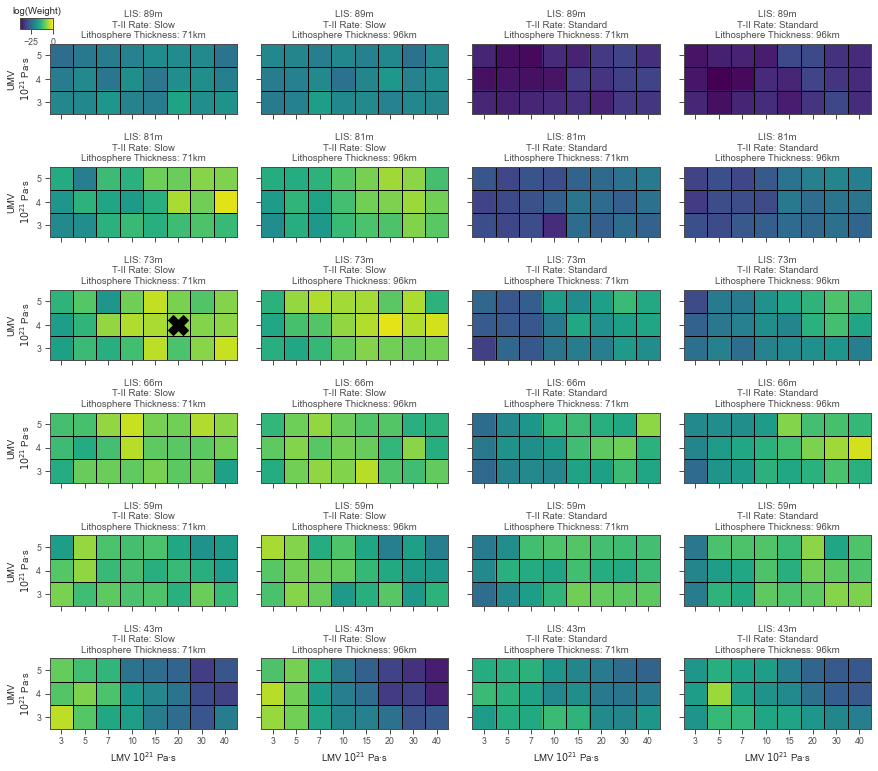

In [7]:
fig=plot_weights(models_df,experiments,'weight',synthetic = True)
fig.savefig("GIA_weights_synthetic.pdf", bbox_inches="tight", dpi=300)

**Fig. S6.** This Figure is identical to Fig.3 except that it uses our synthetic data (see Supplement).The GIA model used to generate the synthetic data is marked by an **X**.